In [1]:
from langchain_openai import AzureChatOpenAI
from langchain.prompts import ChatPromptTemplate
import os

import truststore
truststore.inject_into_ssl()
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
os.environ["APP_CLIENT_ID"] = "zizhang-chen-research-app"
os.environ["APP_CLIENT_SECRET"] = "cQPcueFP7tDrimbf8NW2GAHcHeQa"
from llm_idam_token_generator.idam_token_generator import get_idam_token

# OpenAI Endpoint details
OPENAI_ENDPOINT = "https://openai-llm-frontdoor-hma7evbthrd4cugn.a01.azurefd.net"
# OPENAI_DEPLOYMENT_MODEL = "gpt-4-32k-beta"
# OPENAI_DEPLOYMENT_MODEL = "gpt-3.5-turbo"
OPENAI_DEPLOYMENT_MODEL = "gpt-4o"
OPENAI_AZURE_API_VERSION = "2023-12-01-preview"
# OPENAI_AZURE_API_VERSION = '2024-02-01'
OPENAI_TYPE = "azure"


ModuleNotFoundError: No module named 'truststore'

In [2]:
llm = AzureChatOpenAI(
    api_key="xxx",  # This is not playing any role, but required as per OpenAI sdk. So any random could be passed.
    azure_endpoint=OPENAI_ENDPOINT,
    deployment_name=OPENAI_DEPLOYMENT_MODEL,
    openai_api_version=OPENAI_AZURE_API_VERSION,
    n = 2,
    default_headers={
        'Authorization': f'Bearer {get_idam_token()}',
        'Content-Type': 'application/json'
    }
)

PID:73524 INFO llm_idam_token_generator.idam_token_generator - Client ID: zizhang-chen-research-app - Generating new token.
PID:73524 INFO llm_idam_token_generator.idam_token_generator - Client ID: zizhang-chen-research-app - All required environment variables are present.
/opt/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
PID:73524 INFO llm_idam_token_generator.idam_token_generator - Client ID: zizhang-chen-research-app - IDAM Access Token is generated
/opt/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-w

In [3]:
prompt = ChatPromptTemplate.from_template("what is the city {person} is from?")
chain = prompt | llm
result = chain.invoke({"person": "Narendra modi"})

PID:73524 INFO httpx - Client ID: zizhang-chen-research-app - HTTP Request: POST https://openai-llm-frontdoor-hma7evbthrd4cugn.a01.azurefd.net/openai/deployments/gpt-4o/chat/completions?api-version=2023-12-01-preview "HTTP/1.1 200 OK"


In [3]:
def generate_prompt_task(path):
    with open(path) as f:
        prompt = f.readlines()
    return prompt

def generate_cot():

    cot = ["1. **Review Patient Profile:** Analyze age, sex, and medical history for any factors that significantly increase ICU transfer risk.",
    "2. **Evaluate Current Symptoms:** Consider how severe the symptoms are and whether they suggest worsening of condition or stability.",
    "3. **Assess Vital Signs:** Identify any vital signs that are outside normal ranges and what they indicate about the patient's current health status.",
    "4. **Interpret Laboratory Results:** Look for abnormalities in lab results that could signal a need for intensive care, such as organ dysfunction or severe infection.",
    "5. **Consider Medical Events Since Admission:** Determine if the medical events reported since admission suggest a trend towards improvement or deterioration.",
    "6. **Make Prediction:** Based on the analysis, predict if ICU transfer is likely and justify the decision with specific medical reasoning."]

    notice = "**Notice:** Please be as conservative as possible, false Yes may cause serious financial loss.\n"
    
    return notice + '\n'.join(cot) 

def combin_prompt_with_cot(general_prompt, cot, medical_event):
    template_by_task = '**Task:**\n' + general_prompt + '\n'
    
    template_cot = '**Chain of Thought Analysis:**\n'+ cot + '\n'

    template_events = '**Medical Events**\n' + medical_event + '\n'

    cot_template = template_by_task + '\n' + template_cot + '\n' + '{events}'
    return cot_template, template_events

def combin_prompt_no_cot(general_prompt, medical_event):
    template_by_task = '**Task:**\n' + general_prompt + '\n'
    
    template_events = '**Medical Events**\n' + medical_event + '\n'

    cot_template = template_by_task + '\n' + '{events}'
    return cot_template, template_events

def sample_indices(seed, array_A, sample_size, min_true_count):
    if array_A.size < sample_size:
        raise ValueError("The size of array A must be at least as large as the sample size.")
    if np.count_nonzero(array_A) < min_true_count:
        raise ValueError("Array A does not contain enough True values.")
    
    np.random.seed(seed)  # Set the random seed for reproducibility
    
    # Indices of True and False in array_A
    true_indices = np.where(array_A)[0]
    false_indices = np.where(~array_A)[0]
    
    if len(true_indices) < min_true_count:
        raise ValueError("Array A contains fewer than the minimum required True values.")
    
    # Sample at least min_true_count True indices
    selected_true_indices = np.random.choice(true_indices, min_true_count, replace=False)
    
    # Remaining indices needed to be picked
    remaining_indices_needed = sample_size - min_true_count
    
    # Create a pool of indices excluding the selected True indices
    remaining_pool = np.setdiff1d(np.arange(array_A.size), selected_true_indices)
    
    # Sample the remaining indices from the pool
    selected_other_indices = np.random.choice(remaining_pool, remaining_indices_needed, replace=False)
    
    # Combine the selected indices
    final_indices = np.concatenate((selected_true_indices, selected_other_indices))
    
    # Shuffle the final indices to randomize their order
    return final_indices

In [4]:
general_prompt = generate_prompt_task('prompts/ICU_cot.txt')[0]
cot = generate_cot()

df = pd.read_csv('common_patients_description.csv')
description_list = df['description']

icu_patients = pd.read_csv('icu_labeled_patients.csv')
icu_patients.rename(columns={'prediction_time': 'admission_date'}, inplace=True)
df2 = df.merge(icu_patients[['patient_id', 'admission_date', 'value']], on=['patient_id', 'admission_date'], how='left')

gt_array = df2['value']
i_list = sample_indices(42, gt_array, 100, 20)
gt_list = gt_array[i_list]

c, e = combin_prompt_with_cot(general_prompt, cot, description_list[0])


FileNotFoundError: [Errno 2] No such file or directory: 'prompts/ICU_cot.txt'

In [6]:
print(c, e)

**Task:**
You are an experienced doctor. Based on the provided patient age and medical events, use your medical knowledge and reasoning to predict whether the patient will be transferred to the ICU on the same admission date. Shortly explain your reasoning step by step, considering the critical factors that would influence such a decision. In the Last line, based on the previous analysis, please only answer with Yes or No. Yes if the patient will be transfered to ICU, No, if the patient will not be transfered to ICU.

**Chain of Thought Analysis:**
**Notice:** Please be as conservative as possible, false Yes may cause serious financial loss.
1. **Review Patient Profile:** Analyze age, sex, and medical history for any factors that significantly increase ICU transfer risk.
2. **Evaluate Current Symptoms:** Consider how severe the symptoms are and whether they suggest worsening of condition or stability.
3. **Assess Vital Signs:** Identify any vital signs that are outside normal ranges an

In [7]:
# answer_list_all = []
# for i in tqdm(i_list):
# # for i in tqdm([1]):
#     answer_list_5 = []
#     for _ in tqdm(range(5)):
#         c, e = combin_prompt_no_cot(general_prompt, description_list[i])
#         prompt = ChatPromptTemplate.from_template(c)
#         chain = prompt | llm
#         result = chain.invoke({'events': e })
#         answer_list_5.append(result.content)
#     answer_list_all.append(answer_list_5)
#     time.sleep(2)

  0%|          | 0/100 [00:00<?, ?it/s]PID:46932 INFO httpx - Client ID: zizhang-chen-research-app - HTTP Request: POST https://openai-llm-frontdoor-hma7evbthrd4cugn.a01.azurefd.net/openai/deployments/gpt-4-32k-beta/chat/completions?api-version=2023-12-01-preview "HTTP/1.1 200 OK"
PID:46932 INFO httpx - Client ID: zizhang-chen-research-app - HTTP Request: POST https://openai-llm-frontdoor-hma7evbthrd4cugn.a01.azurefd.net/openai/deployments/gpt-4-32k-beta/chat/completions?api-version=2023-12-01-preview "HTTP/1.1 200 OK"
PID:46932 INFO httpx - Client ID: zizhang-chen-research-app - HTTP Request: POST https://openai-llm-frontdoor-hma7evbthrd4cugn.a01.azurefd.net/openai/deployments/gpt-4-32k-beta/chat/completions?api-version=2023-12-01-preview "HTTP/1.1 200 OK"
PID:46932 INFO httpx - Client ID: zizhang-chen-research-app - HTTP Request: POST https://openai-llm-frontdoor-hma7evbthrd4cugn.a01.azurefd.net/openai/deployments/gpt-4-32k-beta/chat/completions?api-version=2023-12-01-preview "HTTP/1

KeyboardInterrupt: 

In [13]:
answer_list_all = []
for i in tqdm(i_list):
# for i in tqdm([1]):
    answer_list_5 = []
    for _ in tqdm(range(5)):
        c, e = combin_prompt_no_cot(general_prompt, description_list[i])
        prompt = ChatPromptTemplate.from_template(c)
        chain = prompt | llm
        result = chain.invoke({'events': e })
        answer_list_5.append(result.content)
    answer_list_all.append(answer_list_5)
    time.sleep(2)

  0%|          | 0/100 [00:00<?, ?it/s]PID:46932 INFO httpx - Client ID: zizhang-chen-research-app - HTTP Request: POST https://openai-llm-frontdoor-hma7evbthrd4cugn.a01.azurefd.net/openai/deployments/gpt-4-32k-beta/chat/completions?api-version=2023-12-01-preview "HTTP/1.1 200 OK"
PID:46932 INFO httpx - Client ID: zizhang-chen-research-app - HTTP Request: POST https://openai-llm-frontdoor-hma7evbthrd4cugn.a01.azurefd.net/openai/deployments/gpt-4-32k-beta/chat/completions?api-version=2023-12-01-preview "HTTP/1.1 200 OK"
PID:46932 INFO httpx - Client ID: zizhang-chen-research-app - HTTP Request: POST https://openai-llm-frontdoor-hma7evbthrd4cugn.a01.azurefd.net/openai/deployments/gpt-4-32k-beta/chat/completions?api-version=2023-12-01-preview "HTTP/1.1 200 OK"
PID:46932 INFO httpx - Client ID: zizhang-chen-research-app - HTTP Request: POST https://openai-llm-frontdoor-hma7evbthrd4cugn.a01.azurefd.net/openai/deployments/gpt-4-32k-beta/chat/completions?api-version=2023-12-01-preview "HTTP/1

In [14]:
df_pred = pd.DataFrame(answer_list_all)
df_pred.columns = ['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5']
df_pred['gt'] = gt_list.values
df_pred['orig_index'] = i_list
df_pred.to_csv('results/ICU_cot.csv')

In [15]:
def calculate_row_entropy(df):
    def entropy(row):
        # Count occurrences of 'Yes' and 'No'
        counts = row.value_counts(normalize=True)
        # Calculate entropy
        return -np.sum(counts * np.log2(counts + np.finfo(float).eps))  # np.finfo(float).eps prevents log(0)

    # Apply the entropy function to each row
    return df.apply(entropy, axis=1)



In [16]:
df_pred_baseline = df_pred.loc[:, ['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5']]
df_pred_baseline.replace({'Yes': 1, 'No': 0}, inplace=True)
uq_metric_baseline = calculate_row_entropy(df_pred_baseline).values
uq_metric_baseline = np.round(uq_metric_baseline, 10) + 0.0000000001

In [17]:
def plot_auc_roc(y_true, scores):
    
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    # Plotting
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
acc_list = []
for c in df_pred_baseline.columns:
    p = df_pred_baseline[c].values
    acc = np.mean(df_pred_baseline[c] == df_pred['gt'].astype(int))
    acc_list.append(acc)

In [27]:
pred_1_numerical = (df_pred['pred_2'] == 'Yes').astype(int).values
pred_gt = (pred_1_numerical == gt_list.values.astype(int))

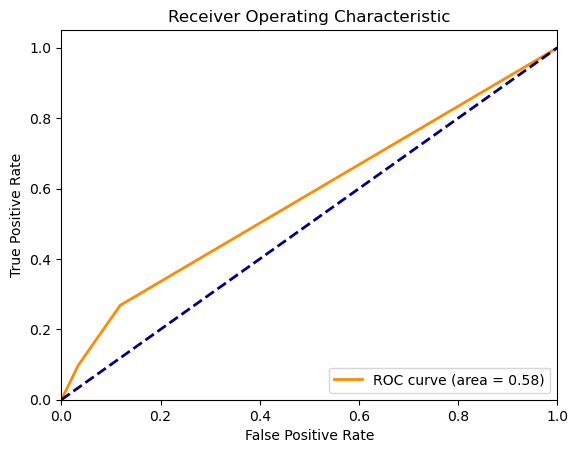

In [28]:
plot_auc_roc(pred_gt, uq_metric_baseline)

In [1]:
df

NameError: name 'df' is not defined

In [22]:
np.mean(acc_list), np.std(acc_list)

(0.38800000000000007, 0.016)